In [3]:
import pandas as pd

df_hn = pd.read_csv("AQI_HaNoi_Updated.csv", parse_dates=["date"],index_col=["date"])
df_dn = pd.read_csv("AQI_DaNang_Updated.csv", parse_dates=["date"],index_col=["date"])
df_vt = pd.read_csv("AQI_VietTri_Updated.csv", parse_dates=["date"],index_col=["date"])

cols = ['AQI']
df_hn = df_hn[cols]
df_dn = df_dn[cols]
df_vt = df_vt[cols]

df_hn.head()

,AQI
date,
2019-01-01,154.285714
2019-01-01,152.857143
2019-01-02,116.666667
2019-01-02,92.000000
2019-01-03,78.000000


In [4]:
import tensorflow as tf

# Tạo lớp NBeatsBlock
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # hàm tạo lấy tất cả các siêu tham số cho lớp
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # đối số **kwargs đảm nhiệm tất cả các đối số cho lớp cha (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Khối chứa 4 lớp 'full_connected', mỗi lớp có kích hoạt ReLU
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Đầu ra của khối là lớp theta có kích hoạt tuyến tính
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # phương thức 'call' sẽ chạy khi lớp được gọi
    x = inputs
    for layer in self.hidden: # chuyển đầu vào qua từng lớp ẩn
      x = layer(x)
    theta = self.theta_layer(x)
    # Xuất 'backcast' và 'forecast' từ theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [5]:
HORIZON = 1 # khoảng thời gian mà mô hình sẽ dự đoán trước
WINDOW_SIZE = 7 # số lượng bước thời gian mà mô hình sẽ nhìn lại để đưa ra dự đoán

In [6]:
# Các giá trị từ bài báo N-BEATS Hình 1 và Bảng 18/Phụ lục D
N_EPOCHS = 5000 # được gọi là "Iterations" trong Bảng 18
N_NEURONS = 512 # được gọi là "Width" trong Bảng 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # được gọi là "Lookback" trong Bảng 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [7]:
from tensorflow.keras import layers
# tạo tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = layers.subtract([tensor_1, tensor_2])

added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [8]:
tf.random.set_seed(42)

# 1. Thiết lập lớp khối N-BEATS
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

In [9]:
# 2. Tạo đầu vào cho ngăn xếp
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

In [10]:
# 3. Tạo đầu vào dự báo và dự báo ngược ban đầu (dự đoán ngược được gọi là phần dư trong bài báo)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

In [11]:
# 4. Tạo ngăn xếp các khối
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Sử dụng NBeatsBlock để tính toán dự báo backcast cũng như khối
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # chuyển nó thành phần dư (backcast)

  # 6. Tạo xếp chồng dư kép
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

In [12]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # trả về mảng dự đoán 1D

In [13]:
def evaluate_preds(y_true, y_pred):
  # Đảm bảo float32 (để tính toán số liệu)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Tính toán các chỉ số khác nhau
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  # Tính đến các số liệu có kích thước khác nhau (đối với tầm nhìn dài hơn, hãy giảm xuống một số)
  if mae.ndim > 0: # nếu mae chưa phải là đại lượng vô hướng, hãy giảm nó thành một bằng cách tổng hợp các tensor thành có nghĩa
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          }

# Hà Nội

In [153]:
# Thêm các cột window
df_nbeats = df_hn.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"AQI+{i+1}"] = df_nbeats["AQI"].shift(periods=i+1)
df_nbeats.dropna().head()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
date,,,,,,,,
2019-01-04,90.000000,111.666667,105.000000,78.000000,92.000000,116.666667,152.857143,154.285714
2019-01-05,136.666667,90.000000,111.666667,105.000000,78.000000,92.000000,116.666667,152.857143
2019-01-05,140.000000,136.666667,90.000000,111.666667,105.000000,78.000000,92.000000,116.666667
2019-01-06,157.142857,140.000000,136.666667,90.000000,111.666667,105.000000,78.000000,92.000000
2019-01-06,152.857143,157.142857,140.000000,136.666667,90.000000,111.666667,105.000000,78.000000


## Hà Nội, Train:Test - 7:3

In [154]:
# Tạo đặc điểm và nhãn
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

# Tạo bộ huấn luyện và bộ kiểm tra
split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1465, 1465, 629, 629)

In [155]:
# 1. Làm mảng huấn luyện và kiểm tra thành Bộ dữ liệu tensor
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Kết hợp các đặc điểm và nhãn
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3.  Chia dữ liệu huấn luyện thành các nhóm nhỏ (batches) and Tự động điều chỉnh số lượng batches để có hiệu suất tối ưu
BATCH_SIZE = 1024 # lấy từ Phụ lục D trong bài báo N-BEATS
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [156]:
# 7. Đặt mô hình ngăn xếp lại với nhau
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_HaNoi_73_N-BEATS")

In [157]:
# 8. Biên dịch với mất MAE và trình tối ưu hóa Adam
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [158]:
# 9. Điều chỉnh mô hình bằng các lệnh gọi lại EarlyStopping và ReduceLROnPlateau
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 116: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 216: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [159]:
# Đánh giá mô hình N-BEATS trên tập dữ liệu thử nghiệm
model.evaluate(test_dataset)

1/1 [==============================] - 0s 32ms/step - loss: 23.4749 - mae: 23.4749 - mse: 906.4369


[23.47490882873535, 23.47490882873535, 906.4368896484375]

In [160]:
# Đưa ra dự đoán với mô hình N-BEATS
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 74.567474,  74.02432 ,  94.81458 , 110.240776,  80.84704 ,
        79.6312  ,  84.652   , 111.572105,  79.62174 ,  90.31961 ],
      dtype=float32)>

In [161]:
# Đánh giá dự đoán mô hình N-Beats
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 23.474909, 'rmse': 30.10709, 'mape': 20.07214}

In [162]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

In [25]:
import matplotlib.pyplot as plt

def predict_future_aqi(model, initial_input, n_days):
    predictions = []
    current_input = initial_input

    for _ in range(n_days):
        # Đưa ra dự đoán cho ngày hôm sau
        next_prediction = model.predict(tf.expand_dims(current_input, axis=0))
        next_prediction = tf.squeeze(next_prediction).numpy()

        predictions.append(next_prediction)

        # Cập nhật cửa sổ đầu vào cho lần lặp tiếp theo
        current_input = np.append(current_input[1:], next_prediction)

    return np.array(predictions)

1/1 [==============================] - 0s 23ms/step


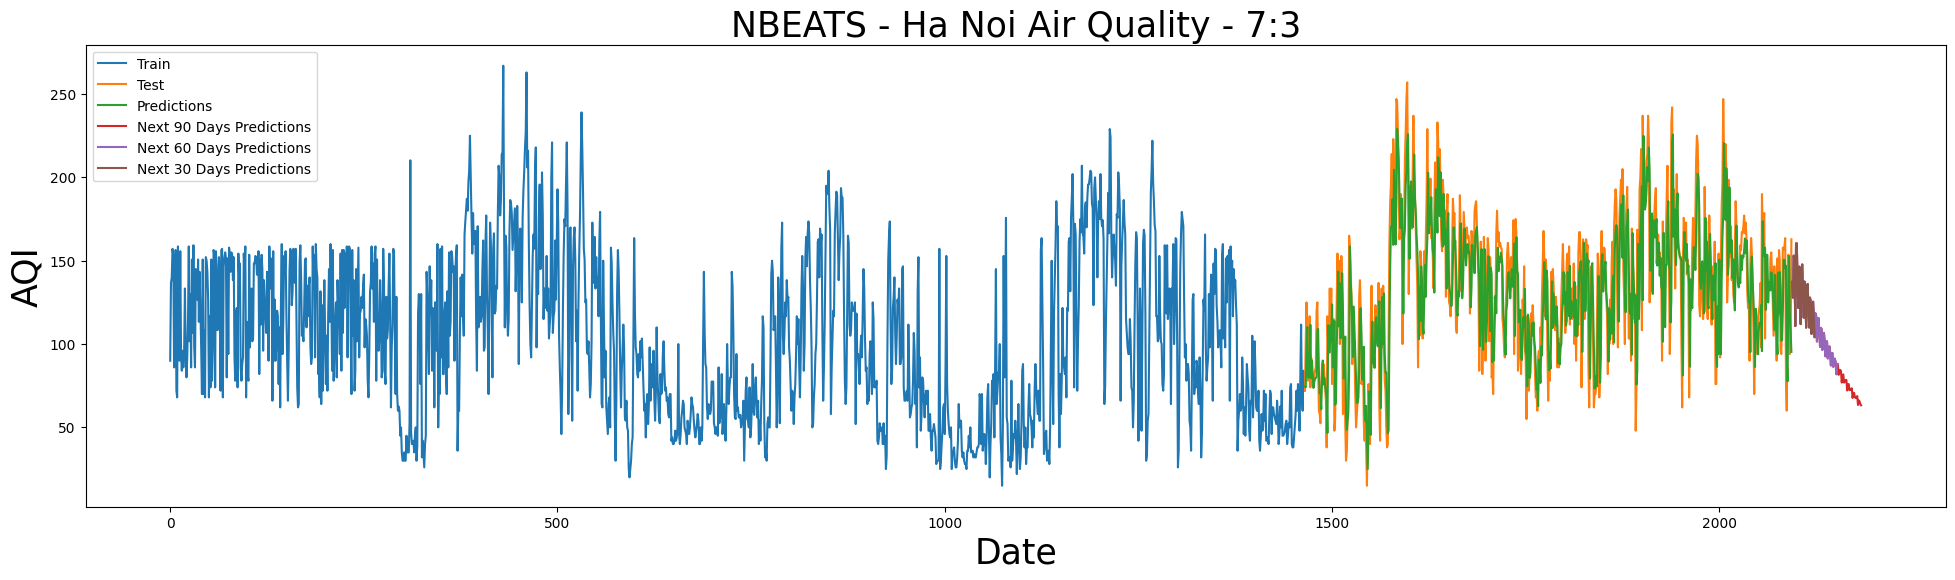

In [164]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Ha Noi Air Quality - 7:3', fontsize = 25)
plt.legend()
plt.show()

## Hà Nội, Train:Test - 8:2

In [165]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1675, 1675, 419, 419)

In [166]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [167]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_HaNoi_82_N-BEATS")

In [168]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [169]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 211: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [170]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 21ms/step - loss: 23.7473 - mae: 23.7473 - mse: 921.8483


[23.747323989868164, 23.747323989868164, 921.8483276367188]

In [171]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([157.62636, 158.21371, 160.15143, 154.18213, 129.72478, 140.004  ,
       161.71834, 155.79515, 159.10245, 146.64114], dtype=float32)>

In [172]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 23.747324, 'rmse': 30.361956, 'mape': 19.654457}

In [173]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 23ms/step


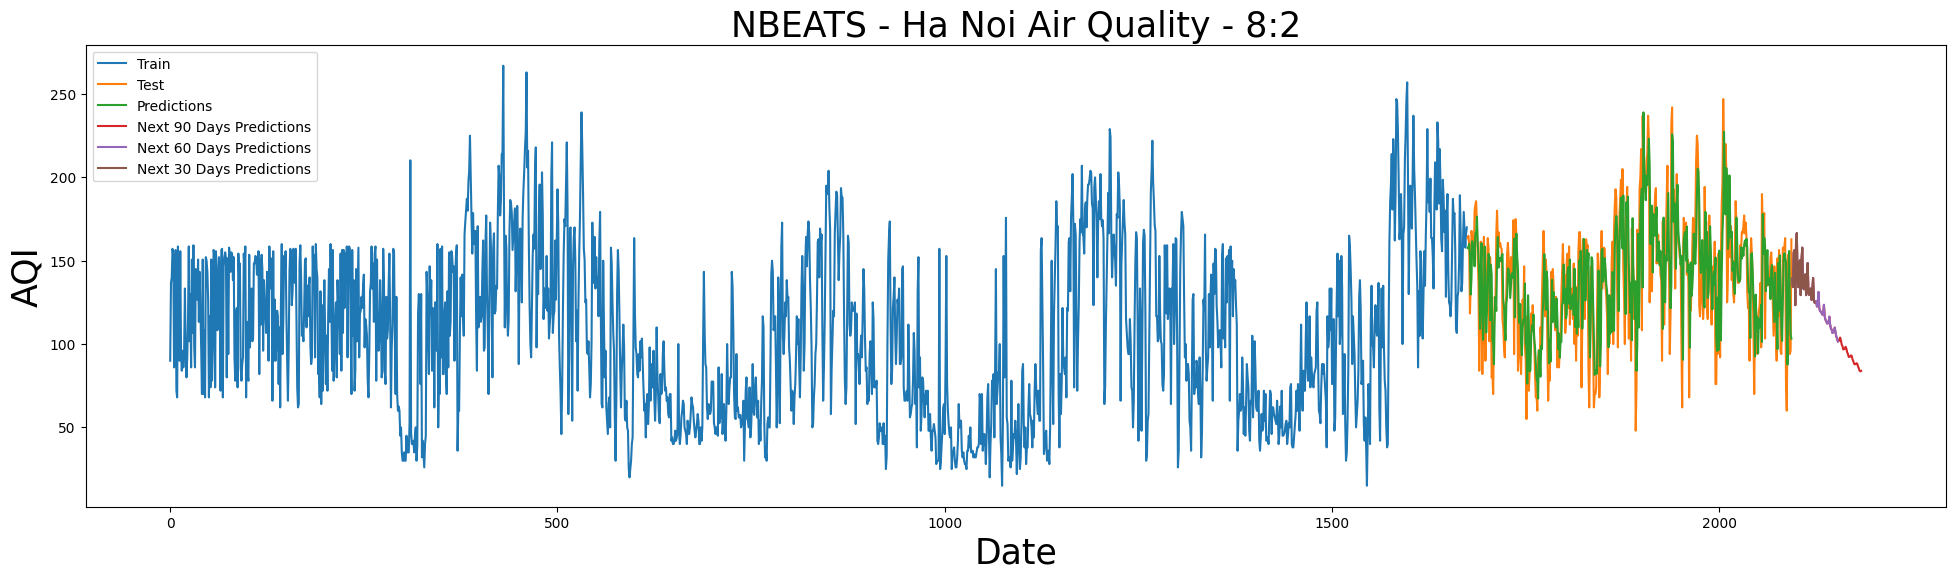

In [174]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Ha Noi Air Quality - 8:2', fontsize = 25)
plt.legend()
plt.show()

## Hà Nội, Train:Test - 9:1

In [175]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1884, 1884, 210, 210)

In [176]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [177]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_HaNoi_91_N-BEATS")

In [178]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [179]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 114: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 214: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [180]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 27ms/step - loss: 25.7420 - mae: 25.7420 - mse: 1139.2728


[25.741968154907227, 25.741968154907227, 1139.2728271484375]

In [181]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([141.67241, 127.30842, 132.67534,  94.4628 , 169.58408, 150.43307,
       132.59831, 114.34647, 135.1159 ,  75.15235], dtype=float32)>

In [182]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 25.741968, 'rmse': 33.753117, 'mape': 20.014631}

In [183]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 24ms/step


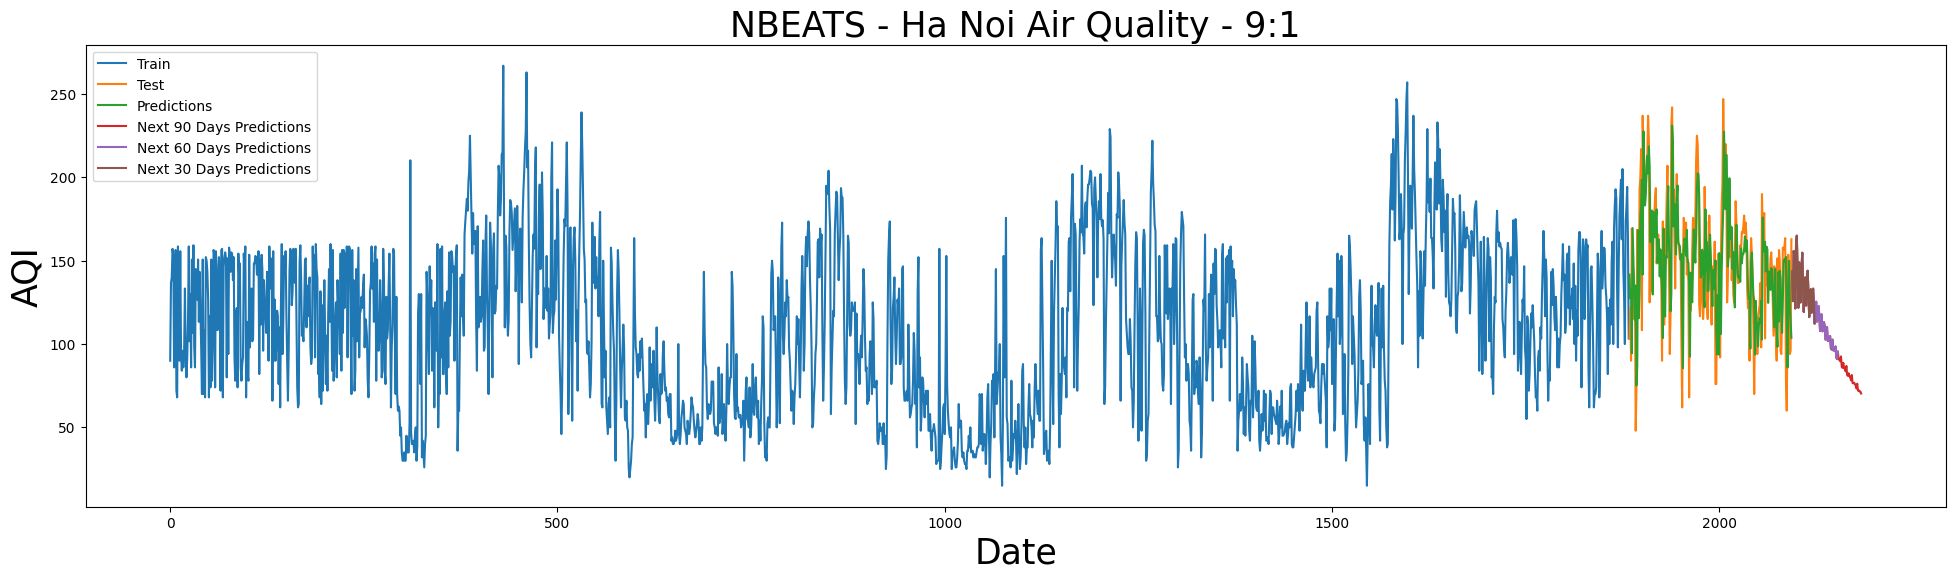

In [184]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Ha Noi Air Quality - 9:1', fontsize = 25)
plt.legend()
plt.show()

# Đà Nẵng

In [14]:
# Thêm các cột window
df_nbeats = df_dn.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"AQI+{i+1}"] = df_nbeats["AQI"].shift(periods=i+1)
df_nbeats.dropna().head()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
date,,,,,,,,
2019-01-08,179.285714,168.571429,153.571429,90.000000,80.000000,64.000000,52.000000,52.0
2019-01-09,152.142857,179.285714,168.571429,153.571429,90.000000,80.000000,64.000000,52.0
2019-01-10,154.285714,152.142857,179.285714,168.571429,153.571429,90.000000,80.000000,64.0
2019-01-11,164.285714,154.285714,152.142857,179.285714,168.571429,153.571429,90.000000,80.0
2019-01-12,148.333333,164.285714,154.285714,152.142857,179.285714,168.571429,153.571429,90.0


## Đà Nẵng, Train:Test - 7:3

In [186]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1380, 1380, 592, 592)

In [187]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [188]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_DaNang_73_N-BEATS")

In [189]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [190]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 211: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [191]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 24.9113 - mae: 24.9113 - mse: 1315.6989


[24.911283493041992, 24.911283493041992, 1315.6988525390625]

In [192]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([71.761986, 77.885124, 77.61791 , 67.9128  , 97.507034, 93.47128 ,
       58.133514, 64.98605 , 89.08902 , 82.0284  ], dtype=float32)>

In [193]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 24.911283, 'rmse': 36.272564, 'mape': 44.02358}

In [194]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 24ms/step


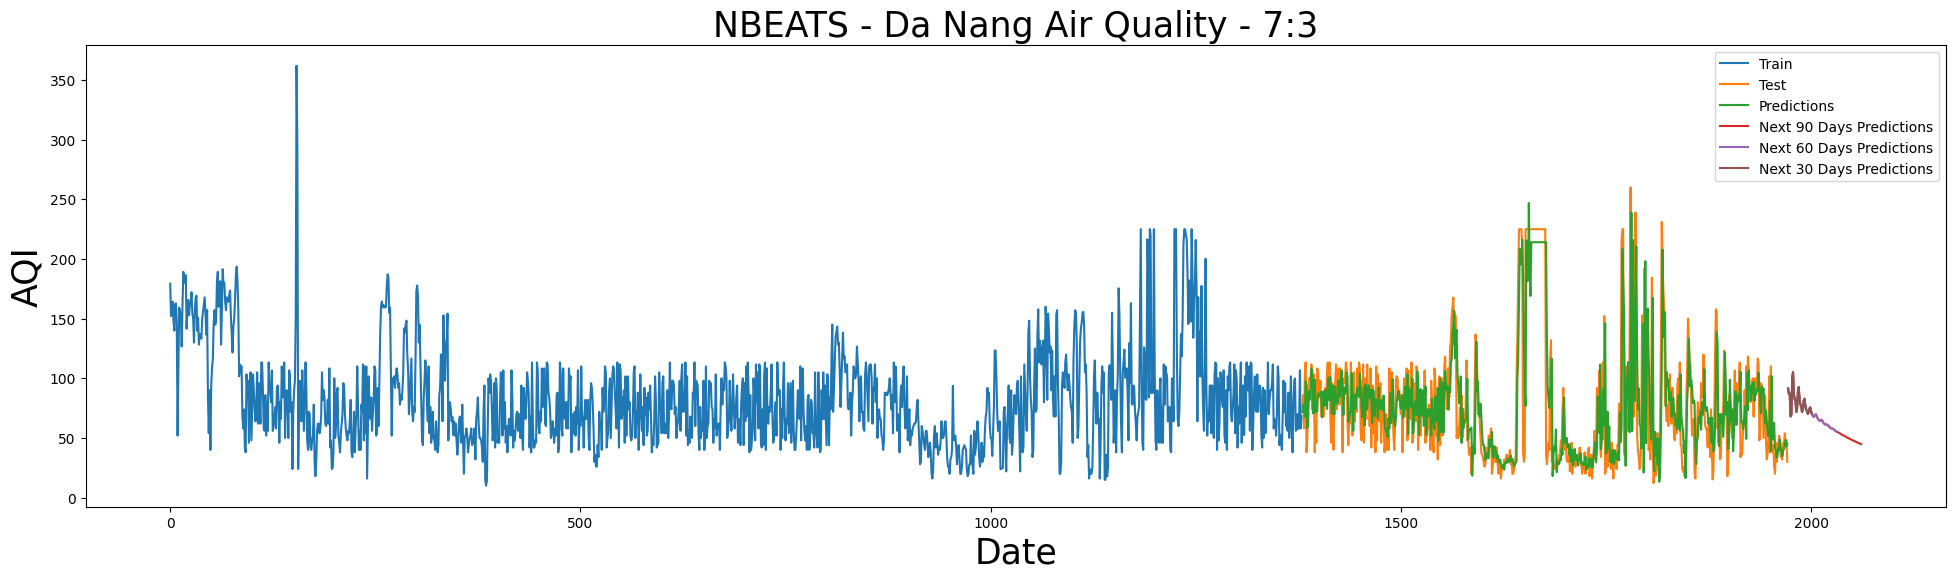

In [195]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Da Nang Air Quality - 7:3', fontsize = 25)
plt.legend()
plt.show()

## Đà Nẵng, Train:Test - 8:2


In [196]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1577, 1577, 395, 395)

In [197]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [198]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_DaNang_82_N-BEATS")

In [199]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [200]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 210: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [201]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 24ms/step - loss: 26.0478 - mae: 26.0478 - mse: 1563.3605


[26.047832489013672, 26.047832489013672, 1563.3604736328125]

In [202]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([62.60006 , 62.357624, 59.7053  , 66.68214 , 96.37494 , 53.170956,
       56.068256, 60.539005, 53.242744, 55.340576], dtype=float32)>

In [203]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 26.047832, 'rmse': 39.539352, 'mape': 48.052704}

In [204]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 23ms/step


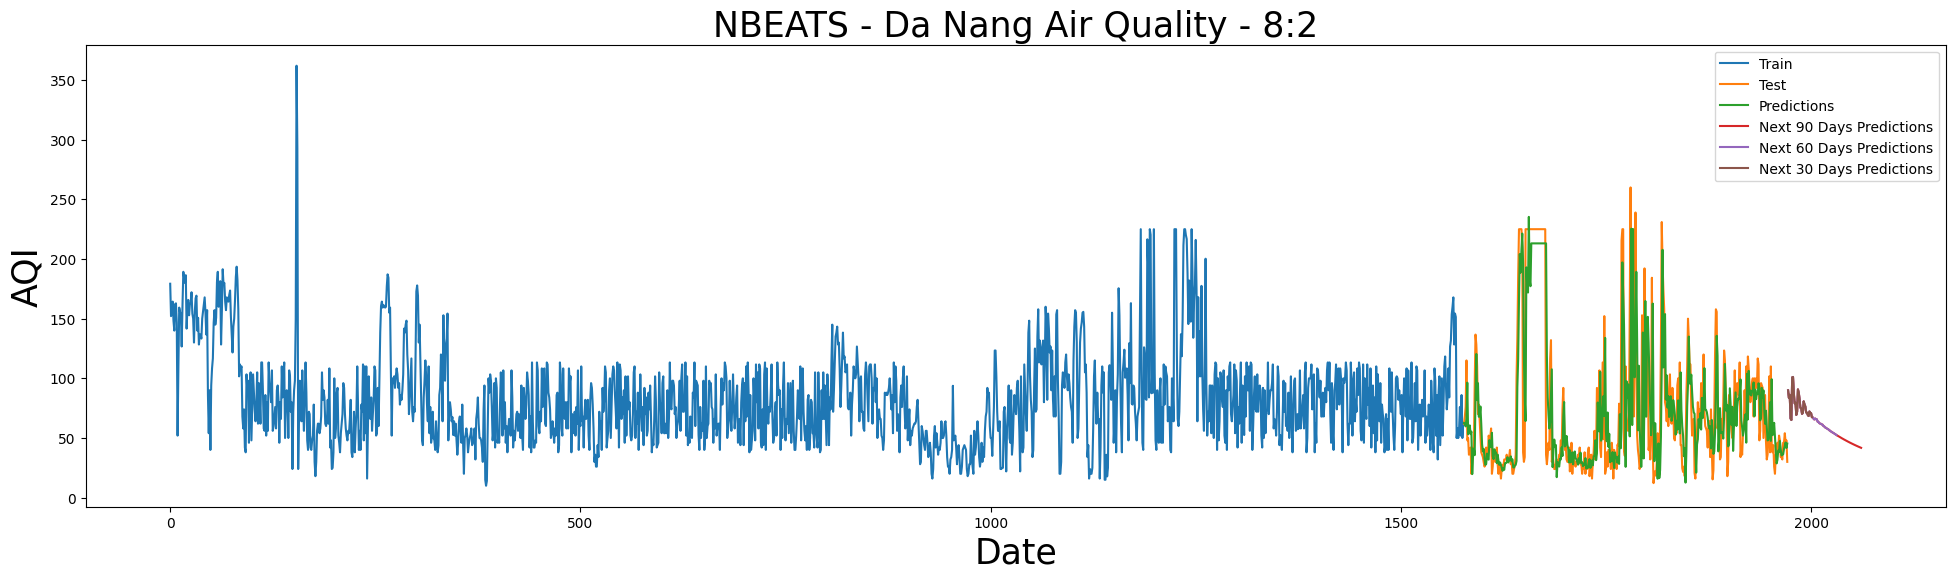

In [205]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Da Nang Air Quality - 8:2', fontsize = 25)
plt.legend()
plt.show()

## Đà Nẵng, Train:Test - 9:1

In [15]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1774, 1774, 198, 198)

In [16]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [17]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_DaNang_91_N-BEATS")

In [18]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [19]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 106: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 206: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [20]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 26ms/step - loss: 28.1154 - mae: 28.1154 - mse: 1545.6169


[28.115442276000977, 28.115442276000977, 1545.616943359375]

In [21]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 49.20977 , 105.62308 ,  94.823944,  88.719536,  75.23823 ,
        52.91183 , 122.36904 , 218.53677 , 129.95944 , 190.32251 ],
      dtype=float32)>

In [22]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 28.115442, 'rmse': 39.314335, 'mape': 47.11372}

In [23]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 37ms/step


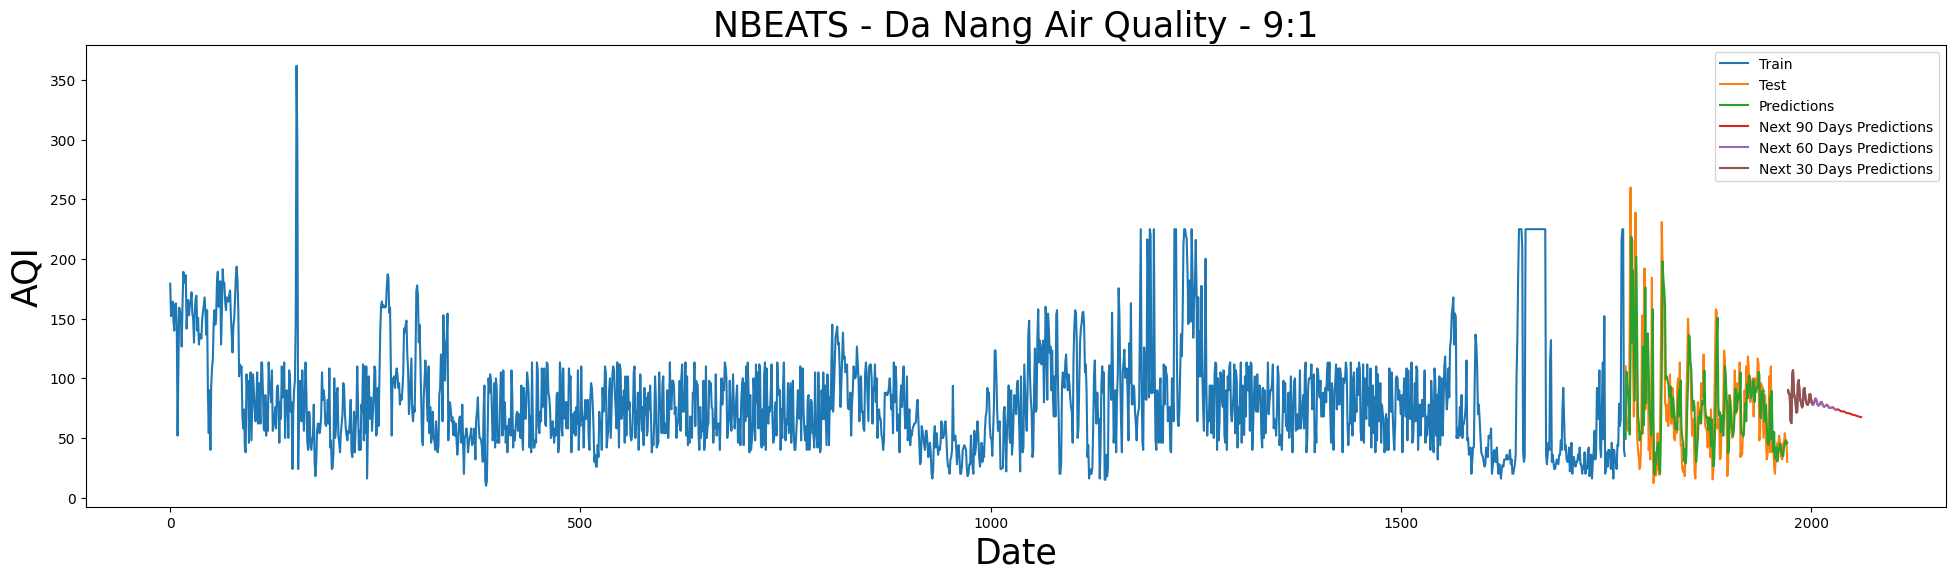

In [26]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Da Nang Air Quality - 9:1', fontsize = 25)
plt.legend()
plt.show()

# Việt Trì

In [27]:
# Thêm các cột window
df_nbeats = df_vt.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"AQI+{i+1}"] = df_nbeats["AQI"].shift(periods=i+1)
df_nbeats.dropna().head()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
date,,,,,,,,
2019-01-08,118.333333,115.000000,84.000000,86.000000,116.666667,60.000000,68.000000,74.000000
2019-01-09,98.000000,118.333333,115.000000,84.000000,86.000000,116.666667,60.000000,68.000000
2019-01-10,111.666667,98.000000,118.333333,115.000000,84.000000,86.000000,116.666667,60.000000
2019-01-11,60.000000,111.666667,98.000000,118.333333,115.000000,84.000000,86.000000,116.666667
2019-01-12,116.666667,60.000000,111.666667,98.000000,118.333333,115.000000,84.000000,86.000000


## Việt Trì, Train:Test - 7:3

In [28]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1380, 1380, 592, 592)

In [29]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [30]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_VietTri_73_N-BEATS")

In [31]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [32]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 211: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [33]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 38ms/step - loss: 22.6248 - mae: 22.6248 - mse: 840.8034


[22.624805450439453, 22.624805450439453, 840.8034057617188]

In [34]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 42s 42s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([81.66432 , 55.70657 , 77.66454 , 75.91232 , 94.500275, 88.8598  ,
       80.88565 , 90.91794 , 76.516205, 66.6979  ], dtype=float32)>

In [35]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 22.624805, 'rmse': 28.99661, 'mape': 34.580227}

In [36]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 25ms/step


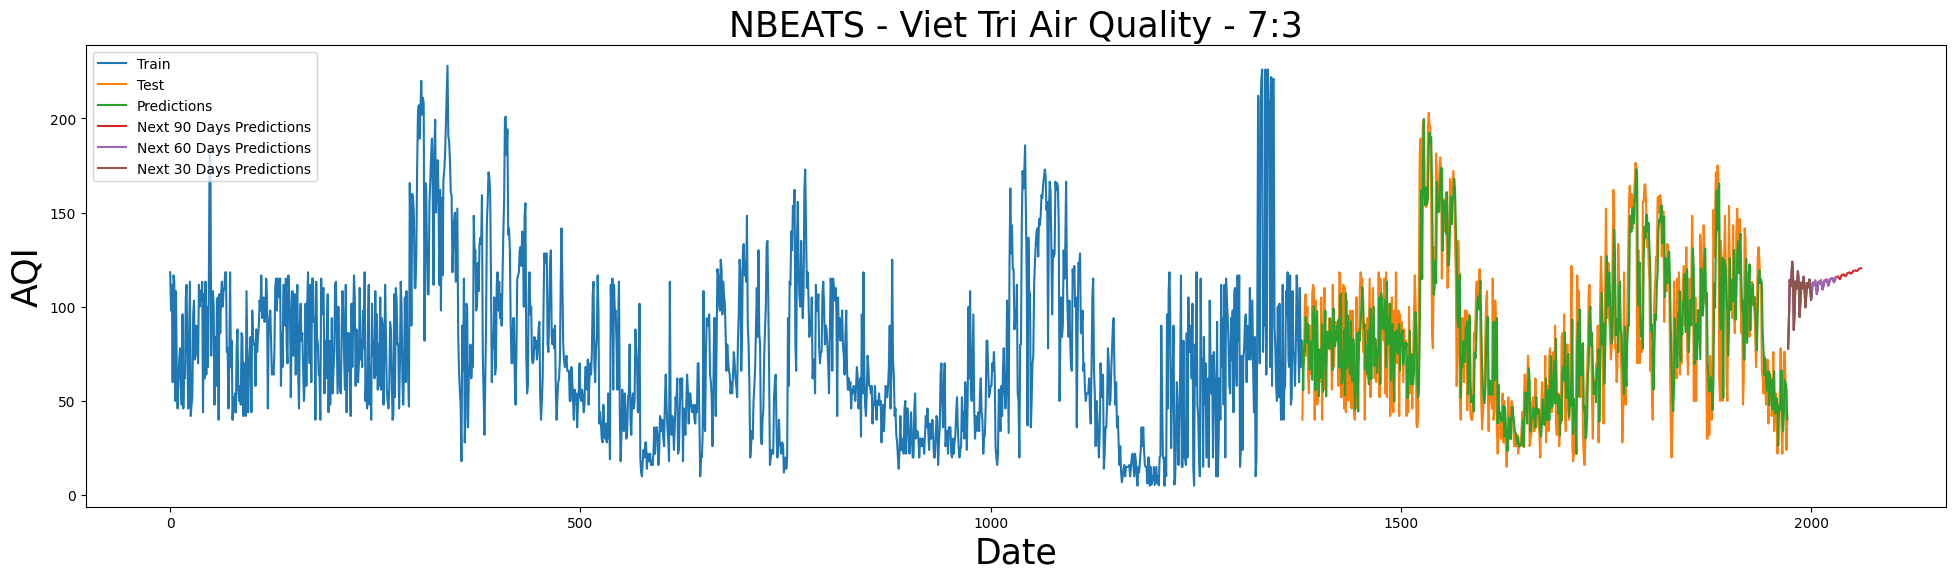

In [37]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Viet Tri Air Quality - 7:3', fontsize = 25)
plt.legend()
plt.show()

## Việt Trì, Train:Test - 8:2

In [38]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1577, 1577, 395, 395)

In [39]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [40]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_VietTri_82_N-BEATS")

In [41]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [42]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 211: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [43]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 45ms/step - loss: 21.7356 - mae: 21.7356 - mse: 774.7480


[21.735578536987305, 21.735578536987305, 774.748046875]

In [44]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([78.898285, 67.71656 , 86.66169 , 84.018524, 81.98695 , 57.36854 ,
       78.338165, 86.86707 , 57.655525, 48.5738  ], dtype=float32)>

In [45]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 21.735579, 'rmse': 27.834295, 'mape': 34.471577}

In [46]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 23ms/step


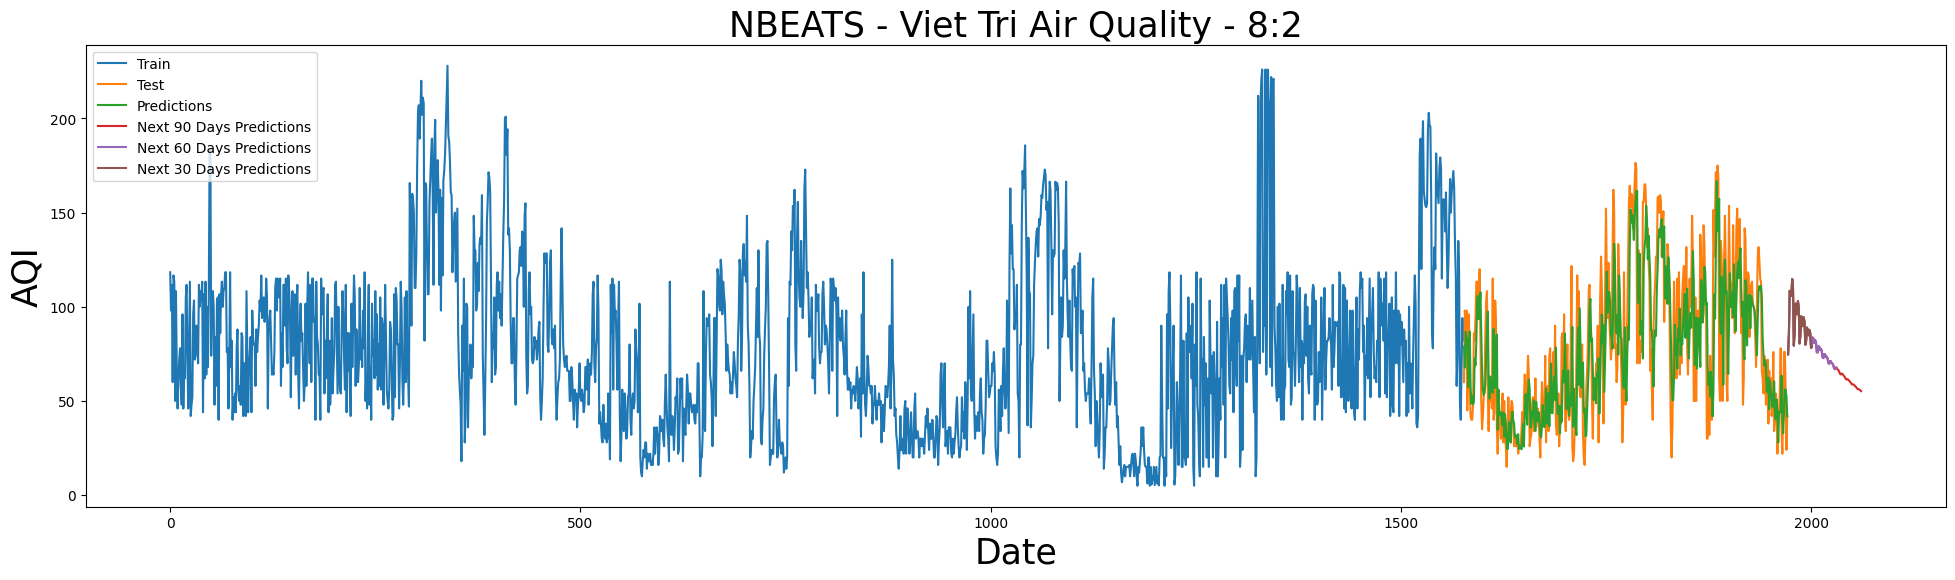

In [47]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Viet Tri Air Quality - 8:2', fontsize = 25)
plt.legend()
plt.show()

## Việt Trì, Train:Test - 9:1

In [48]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1774, 1774, 198, 198)

In [49]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [50]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_VietTri_91_N-BEATS")

In [51]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [52]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 109: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 209: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [53]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 27ms/step - loss: 23.5174 - mae: 23.5174 - mse: 927.8901


[23.517410278320312, 23.517410278320312, 927.89013671875]

In [54]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 62.154507,  51.79812 ,  86.7584  ,  90.381325,  88.27036 ,
       141.6547  , 157.05788 , 147.11499 , 152.83    , 146.3327  ],
      dtype=float32)>

In [55]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 23.51741, 'rmse': 30.461288, 'mape': 32.119083}

In [56]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 25ms/step


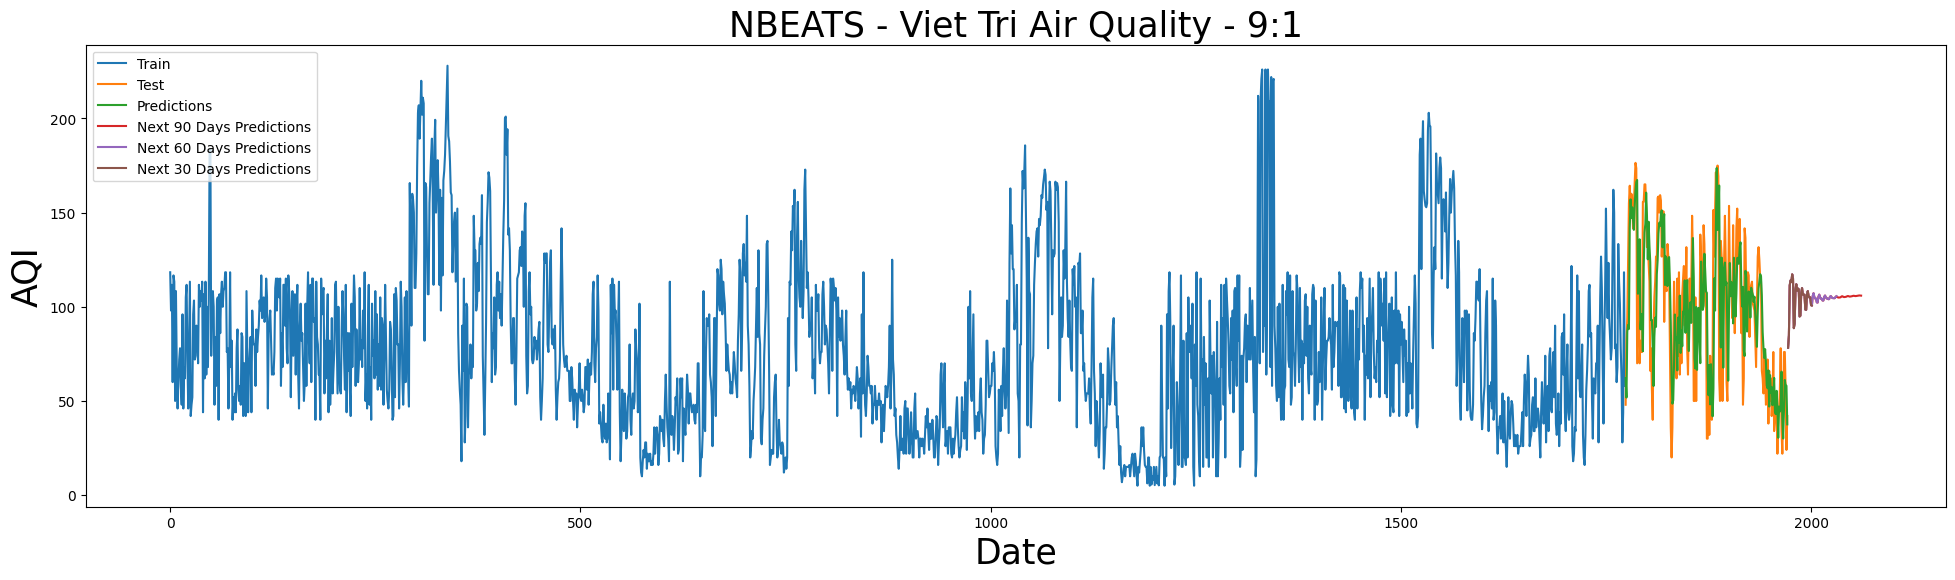

In [57]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-30].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Viet Tri Air Quality - 9:1', fontsize = 25)
plt.legend()
plt.show()